In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272451 sha256=d4e1b91b82c090d4dcad060ef24800e7fadd1f387a4b5612427e24425535053b
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

# Reference to Image Segmentation

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

In [4]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

In [5]:
# Load the annotations of the image dataset
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)
test_coco, test_classes = getCOCO(test_anns_path)

loading annotations into memory...
Done (t=4.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [6]:
def getMask(image_id, coco, classes, image_size):
    # Create a zero array with the given size and number of classes
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        # Get the binary mask for the annotation
        binary = cv2.resize(coco.annToMask(ann), image_size)

        # Get the channel index for the annotation
        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        # Update the channel of the annotation
        mask[:, :, channel] = binary

        # Update the background channel of the annotation
        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

In [7]:
def getGenerator(path, coco, classes, image_size, batch_size):
    c = 0
    n = os.listdir(path)
    random.shuffle(n)  
    
    while (True):
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            img = cv2.imread(path + '/' + n[i])
            img =  cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            img_batch[i-c] = img
            mask_batch[i-c] = mask

        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch

In [8]:
# Get the generators from the paths
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300

train_gen = getGenerator(train_imgs_path, train_coco, train_classes, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
train_length = len(os.listdir(train_imgs_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_imgs_path, val_coco, val_classes, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
val_length = len(os.listdir(val_imgs_path))
print('Number of validation images: {}'.format(val_length))

test_gen = getGenerator(test_imgs_path, test_coco, test_classes, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_length = len(os.listdir(test_imgs_path))
print('Number of test images: {}'.format(test_length))

Number of training images: 24120
Number of validation images: 1269
Number of test images: 1269


In [9]:
def visualise(path, coco, classes, n):
    temp_gen = getGenerator(path, coco, classes, image_size=IMAGE_SIZE, batch_size=n)
    images, masks = next(temp_gen)
    
    for i in range(n):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Background Channel')
        plt.imshow(masks[i][:, :, 0])
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Max of Object Channels')
        plt.imshow(np.max(masks[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.show()

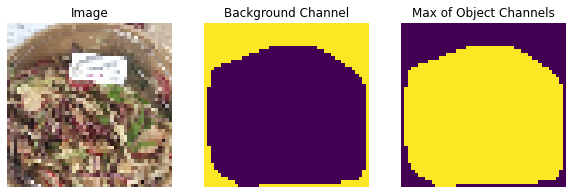

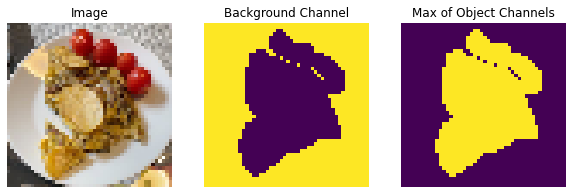

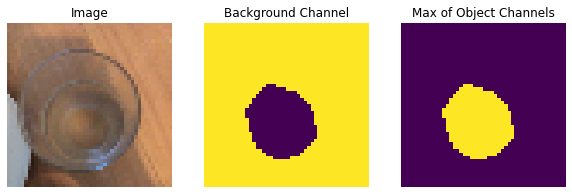

In [10]:
# Visualise a few samples images with their backgrounds and objects
visualise(train_imgs_path, train_coco, train_classes, 3)

In [11]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 116 kB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [12]:
# Define the model to be trained
model = sm.PSPNet('resnet152', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])

234332160/234326024 [==============================] - 5s 0us/step


In [13]:
# # Load the trained model weights
# weights_path = '../input/food-recognition-model/weights.h5'
# model.load_weights(weights_path)

In [14]:
# Train the defined model on the dataset
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=40)

Epoch 1/40
80/80 [==============================] - 598s 7s/step - loss: 0.9954 - iou_score: 0.0086 - precision: 0.0168 - recall: 0.3663 - val_loss: 1.0048 - val_iou_score: 0.0027 - val_precision: 0.0097 - val_recall: 0.3694
Epoch 2/40
80/80 [==============================] - 447s 6s/step - loss: 0.9621 - iou_score: 0.0295 - precision: 0.0648 - recall: 0.4069 - val_loss: 1.0023 - val_iou_score: 0.0069 - val_precision: 0.0310 - val_recall: 0.3697
Epoch 3/40
80/80 [==============================] - 465s 6s/step - loss: 0.9152 - iou_score: 0.0748 - precision: 0.1656 - recall: 0.4264 - val_loss: 0.6685 - val_iou_score: 0.3502 - val_precision: 0.9860 - val_recall: 0.3522
Epoch 4/40
80/80 [==============================] - 450s 6s/step - loss: 0.6550 - iou_score: 0.3616 - precision: 0.9836 - recall: 0.3661 - val_loss: 0.6477 - val_iou_score: 0.3697 - val_precision: 0.9905 - val_recall: 0.3719
Epoch 5/40
80/80 [==============================] - 462s 6s/step - loss: 0.6511 - iou_score: 0.3642 

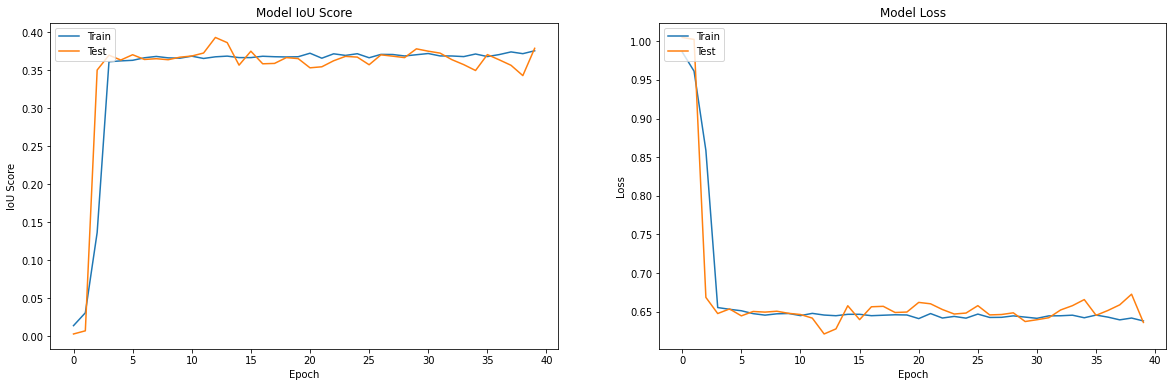

In [15]:
# Plot the loss and iou score over the epochs
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# Save the model to the output
model.save_weights('weights.h5')

In [17]:
# Evaluate the model on the test generator
scores = model.evaluate(test_gen, steps=test_length//BATCH_SIZE)
print('\nLoss: {}'.format(round(scores[0], 3)))
print('Average IoU: {}'.format(round(scores[1], 3)))
print('Average Precision: {}'.format(round(scores[2], 3)))
print('Average Recall: {}'.format(round(scores[3], 3)))

4/4 [==============================] - 28s 9s/step - loss: 0.6553 - iou_score: 0.3598 - precision: 0.9833 - recall: 0.3642

Loss: 0.655
Average IoU: 0.36
Average Precision: 0.983
Average Recall: 0.364
